In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

In [2]:
# Preprocessing
# np_img1 = plt.imread('../data/curie.pgm').astype('float')
np_img1 = plt.imread('../data/einstein.png').astype('float')[:,:,0]
# np_img1 = plt.imread('../data/cat7-elephant1.png').astype('float')

# normalize values between 0-1
np_img1 = po.rescale(np_img1)

# if len(np_img1.shape) == 2:                  # if no channel dimension exists
#     np_img1 = np.expand_dims(np_img1, axis=-1)
# np_img1 = np.transpose(np_img1, (2, 0, 1))   # adjust dimensions for pytorch
# np_img1 = np.expand_dims(np_img1, axis=0)    # add batch dimension
# np_img1 = np_img1 / 255.0                    # normalize values between 0-1
# np_img1 = np_img1.astype(np.float32)         # adjust type

# img1 = torch.from_numpy(np_img1)
img1 = torch.tensor(np_img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
img2 = torch.rand_like(img1, requires_grad=True).to(device)

img1.requires_grad = False
img2.requires_grad = True

In [3]:
# loss_func = lambda x, y: 1 - po.synth.ssim(x, y)
# loss_func = lambda x, y: 1 - po.synth.msssim(x, y)
# loss_func = po.synth.nlpd
loss_func = po.synth.nspd

value = loss_func(img1, img2)
print("Initial distance: %.5f" % (value.item()))
assert value.requires_grad

Initial distance: 13.77170


In [4]:
optimizer = optim.Adam([img2], lr=0.01, amsgrad=True)

# MSSSIM yields higher values for worse results,
# because noise is removed in scales with lower resolutions

# threshold = 0.5
threshold = 0.001
max_iter = 500

I = []
l = []
i = 0
while value > threshold and i < max_iter:

    i += 1
    optimizer.zero_grad()
    loss = loss_func(img1, img2)
    value = loss.item()
    print('Current distance = %.5f' % value)
    loss.backward()
    optimizer.step()
    
    l.append(value)
    I.append(numpy(img2).copy())

Current distance = 13.77170
Current distance = 12.69446
Current distance = 11.64839
Current distance = 10.64219
Current distance = 9.68193
Current distance = 8.77038
Current distance = 7.90801
Current distance = 7.09404
Current distance = 6.32561
Current distance = 5.59856
Current distance = 4.91602
Current distance = 4.29993
Current distance = 3.80013
Current distance = 3.47871
Current distance = 3.36487
Current distance = 3.41970
Current distance = 3.55479
Current distance = 3.69265
Current distance = 3.78485
Current distance = 3.80532
Current distance = 3.74278
Current distance = 3.59549
Current distance = 3.37021
Current distance = 3.08326
Current distance = 2.76864
Current distance = 2.50983
Current distance = 2.45254
Current distance = 2.55144
Current distance = 2.63827
Current distance = 2.65415
Current distance = 2.59285
Current distance = 2.46362
Current distance = 2.28864
Current distance = 2.12719
Current distance = 2.09159
Current distance = 2.15480
Current distance = 2.200

Current distance = 1.11339
Current distance = 1.11768
Current distance = 1.11106
Current distance = 1.11639
Current distance = 1.10910
Current distance = 1.11621
Current distance = 1.10905
Current distance = 1.11370
Current distance = 1.10698
Current distance = 1.11270
Current distance = 1.10536
Current distance = 1.11221
Current distance = 1.10532
Current distance = 1.10968
Current distance = 1.10292
Current distance = 1.10917
Current distance = 1.10203
Current distance = 1.10813
Current distance = 1.10147
Current distance = 1.10583
Current distance = 1.09906
Current distance = 1.10580
Current distance = 1.09893
Current distance = 1.10374
Current distance = 1.09721
Current distance = 1.10287
Current distance = 1.09624
Current distance = 1.10154
Current distance = 1.09495
Current distance = 1.10072
Current distance = 1.09442
Current distance = 1.09878
Current distance = 1.09225
Current distance = 1.09906
Current distance = 1.09290
Current distance = 1.09604
Current distance = 1.08969
C

Difference statistics:
  Range: [-1, 1]
  Mean: -0.009577,  Stdev (rmse): 0.307851,  SNR (dB): -5.503548

 1 - ssim: 0.96309 
 1 - ms-ssim: 0.88959 
 nlpd: 3.25734 
 nspd: 1.07535 



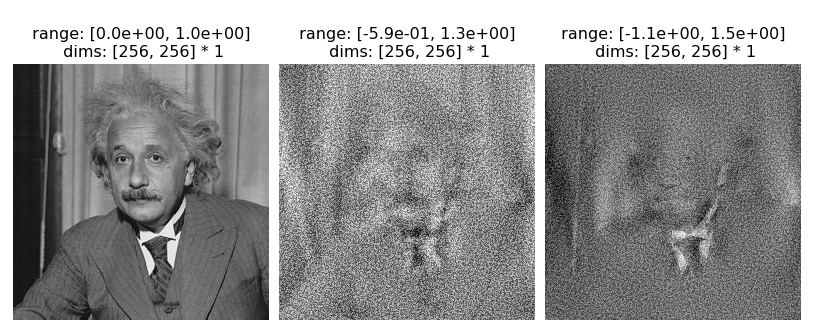

In [5]:
pt.imshow([numpy(img1), numpy(img2), numpy(img1) - numpy(img2)]);
pt.image_compare(numpy(img1), numpy(img2))

print('\n 1 - ssim: %.5f \n 1 - ms-ssim: %.5f \n nlpd: %.5f \n nspd: %.5f \n' % (
    1 - po.synth.ssim(img1, img2), 1 - po.synth.msssim(img1, img2), po.synth.nlpd(img1, img2), po.synth.nspd(img1, img2)))

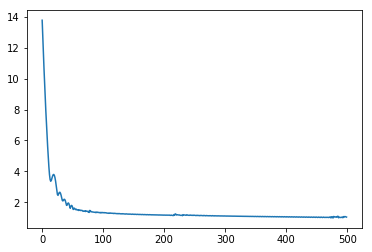

In [6]:
plt.plot(l)

In [7]:
pt.animshow(np.array(I), 25)

In [8]:
# def post_process(img):
#     img = img.detach().cpu().numpy()
#     img = np.transpose(np.squeeze(img, axis=0), (1, 2, 0))
#     img = np.squeeze(img)     # works if grayscale
#     return img

# # Post processing
# img1np = post_process(img1)
# img2 = torch.sigmoid(img2)
# img2np = post_process(img2)

# import matplotlib.pyplot as plt
# cmap = 'gray' if len(img1np.shape) == 2 else None
# plt.subplot(1, 2, 1)
# plt.imshow(img1np, cmap=cmap)
# plt.title('Original')
# plt.subplot(1, 2, 2)
# plt.imshow(img2np, cmap=cmap)
# plt.title('Generated, metric: {:.3f}'.format(value))
# plt.show()

In [9]:
im = []
for i in range(1,25):
    if i < 10:
        i = str(0) + str(i)
    im.append(plt.imread('/Users/pe/Documents/images/tid2013/reference_images/I'+str(i)+'.BMP'))

In [10]:
X = torch.tensor(po.rescale(np.transpose(np.stack(im), (0,3,1,2))), dtype=torch.float32)

X.shape

torch.Size([24, 3, 384, 512])

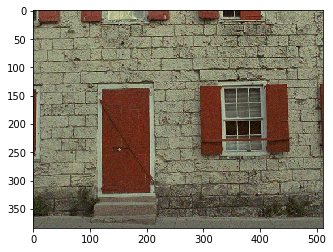

In [11]:
plt.imshow(plt.imread('/Users/pe/Documents/images/tid2013/distorted_images/i01_01_2.bmp'))

In [32]:
dtype = torch.float32

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [37]:
num_images = 25
num_distortions = 24
num_levels = 5

nlpd = []

for i in range(1, num_images + 1):
    if i < 10:
        i = str(0) + str(i)
    
    a = plt.imread('/Users/pe/Documents/images/tid2013/reference_images/I' + str(i) + '.BMP')

    for d in range(1, num_distortions + 1):
        if d < 10:
            d = str(0) + str(d)

        for l in range(1, num_levels + 1):
            if d == '01' and l == 1:
                im = 'I' + str(i)
            else:
                im = 'i' + str(i)
            b = plt.imread('/Users/pe/Documents/images/tid2013/distorted_images/' + im + '_' + str(d) + '_' + str(l) + '.bmp')
            
            A = torch.tensor(rgb2gray(a), dtype=dtype, device=device).unsqueeze(0).unsqueeze(0)
            B = torch.tensor(rgb2gray(b), dtype=dtype, device=device).unsqueeze(0).unsqueeze(0)
            
            nlpd.append(po.synth.perceptual_distance.nlpd(A, B))

In [44]:
nlpd = np.array(nlpd)

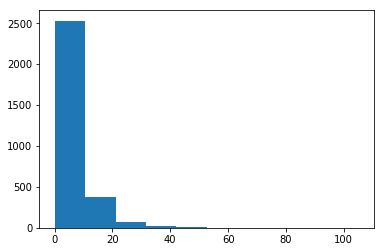

In [48]:
plt.hist(nlpd);

In [41]:
mos = np.loadtxt('/Users/pe/Documents/images/tid2013/mos.txt')

mos.shape

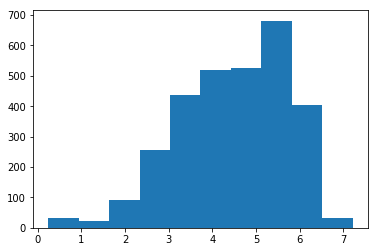

In [49]:
plt.hist(mos);

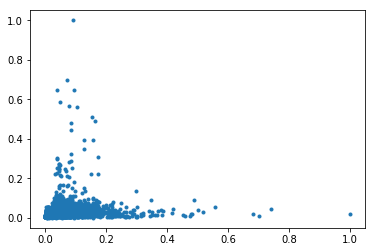

In [58]:
plt.plot(po.rescale(nlpd), po.rescale(1 / (mos)), '.')

In [60]:
(nlpd / np.linalg.norm(nlpd)) @ ((1 / mos) / np.linalg.norm(1 / mos))

0.5937195376060148